<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/CNNs/Deep%20Architectures/CUDA/Model%20Zoo/GoogleNet/GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [2]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

Tesla T4
1


In [3]:
gpu = torch.device('cuda:0')
gpu

device(type='cuda', index=0)

## Dataset, transforms, and visualisation

In [4]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
num_classes = 10

In [7]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

##Inception Model

In [8]:
from torchvision import models

In [9]:
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [10]:
for param in inception.parameters():
    param.requires_grad = False

In [11]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [12]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [13]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [14]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [15]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


##Inception Model Class

###Checkpointing

In [16]:
import copy

In [17]:
class inception_network():

    def forward(self, model,X):
        return model(X)
    
    def evaluation(self,model, dataloader):
        total, correct = 0, 0
        for data in dataloader:
          inputs, labels = data
          inputs, labels = inputs.to(gpu), labels.to(gpu)
          outputs, aux_outputs = self.forward(model,inputs)
          _, pred = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (pred == labels).sum().item()
        return 100 * correct / total
    
    def fit(self, model, epochs,trainloader,testloader,loss_fn,opt,batch_size):
          max_epochs =  epochs
          loss_arr = []
          loss_epoch_arr = []
          n_iters = np.ceil(50000/batch_size)
          min_loss = 1000
          best_model = None
          train_x, test_x = None, None
          for epoch in range(epochs):
              for i, data in enumerate(trainloader, 0):
                  
                  inputs, labels = data
                  inputs, labels = inputs.to(gpu), labels.to(gpu)
                  
                  opt.zero_grad()
                  
                  outputs, aux_outputs = self.forward(model,inputs)
                  loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
                  loss.backward()
                  opt.step()
                  
                  if min_loss > loss.item():
                    min_loss = loss.item()
                    best_model = copy.deepcopy(model.state_dict())
                    train_x , test_x = trainloader, testloader
                    print("\n=============================")
                    print('Iteration: %d/%d, Min loss %0.2f\n' % (i+1, n_iters,min_loss))

                  del inputs, labels, outputs
                  torch.cuda.empty_cache()
                  
                  if ((i+1)%625 == 0):
                    print('Iteration: %d/%d, Loss: %0.2f' % (i+1, n_iters, loss.item()))

                  loss_arr.append(loss.item())
              
              loss_epoch_arr.append(loss.item())
              train_acc = self.evaluation(model,trainloader)
              test_acc = self.evaluation(model,testloader)
              print('\nEpoch: %d/%d, Train acc: %0.2f, Test acc: %0.2f\n' % (epoch+1, max_epochs, train_acc,test_acc ) )
          plt.plot(loss_arr)
          plt.show()
          return best_model, train_x, test_x


Iteration: 1/3125, Min loss 3.04


Iteration: 2/3125, Min loss 3.02


Iteration: 11/3125, Min loss 3.00


Iteration: 12/3125, Min loss 2.95


Iteration: 17/3125, Min loss 2.92


Iteration: 18/3125, Min loss 2.86


Iteration: 20/3125, Min loss 2.80


Iteration: 27/3125, Min loss 2.73


Iteration: 47/3125, Min loss 2.64


Iteration: 93/3125, Min loss 2.59


Iteration: 105/3125, Min loss 2.50


Iteration: 116/3125, Min loss 2.48


Iteration: 117/3125, Min loss 2.46


Iteration: 141/3125, Min loss 2.45


Iteration: 162/3125, Min loss 2.31


Iteration: 194/3125, Min loss 2.31


Iteration: 212/3125, Min loss 2.26


Iteration: 215/3125, Min loss 2.23


Iteration: 217/3125, Min loss 2.10


Iteration: 263/3125, Min loss 2.10


Iteration: 286/3125, Min loss 2.06


Iteration: 312/3125, Min loss 1.99


Iteration: 329/3125, Min loss 1.92


Iteration: 417/3125, Min loss 1.86


Iteration: 418/3125, Min loss 1.80


Iteration: 432/3125, Min loss 1.80


Iteration: 480/3125, Min loss 1.74


Iteration: 5

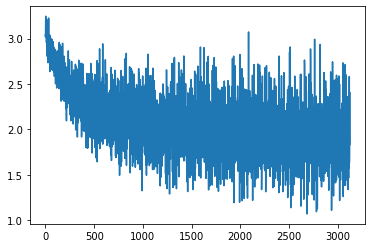

CPU times: user 9min 43s, sys: 2min 14s, total: 11min 57s
Wall time: 12min 4s


In [18]:
%%time
inception = inception.to(gpu)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)
model = inception_network()
best_model, train, test = model.fit(inception,1,trainloader,testloader,loss_fn,opt,batch_size)

In [19]:
inception.load_state_dict(best_model)
print(model.evaluation(inception, train), model.evaluation(inception, test))

46.56 46.54
